In [1]:
import os
import time
import dit
import time
from datetime import datetime
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
os.chdir("../")
from jointpdfpython3.measures import synergistic_entropy_upper_bound
from jointpdfpython3.params_matrix import params2matrix_incremental,matrix2params_incremental
from jointpdfpython3.JointProbabilityMatrix import JointProbabilityMatrix
from syndisc.syndisc import self_disclosure_channel
os.chdir("./plot_notebooks")
import seaborn as sns;sns.set()

## Convergence of scipy minimize (jointpdf)

In [2]:
from scipy.optimize import minimize

# class to save cost values during scipy.optimize.minimize
# note: not used however, but can be used as callback
class OpObj(object):
    def __init__(self, jXS,subjects,sid):
        self.jXS = jXS
        self.subjects=subjects
        self.sid=sid
        self.f = np.full(shape=(500,), fill_value=np.NaN)
        self.count = 0
    def _fun(self):
        totmi = self.jXS.mutual_information(self.subjects,[self.sid])
        indivmis = sum([self.jXS.mutual_information([i],[self.sid]) for i in self.subjects])        
        return totmi-indivmis
    
def cb(xk, obj=None):
    obj.f[obj.count] = obj._fun()
    obj.count += 1

def costf(srvparams,jXS,lenJXS,parX,subjects,upper):
    params2matrix_incremental(jXS,parX+list(srvparams))
    totmi = jXS.mutual_information(subjects,[lenJXS-1])
    indivmis = sum([jXS.mutual_information([i],[lenJXS-1]) for i in subjects])
    cost=(upper-(totmi-indivmis))/upper
    if totmi != 0:
        return cost+((indivmis/totmi))
    else:
        return cost+(indivmis)

## WMS value for increasing repeats (jointpdf)

In [ ]:
x=np.linspace(1,500,500)
states = 2
lenX = 2
subjects = np.arange(lenX)
t='random'
cursyms = []
data = {'systemID':[],'repeats':[],'WMS(X;S)':[],'upper':[],'difference WMS':[]}
samples = 25
samps = [JointProbabilityMatrix(lenX+1,states) for _ in range(samples)]
lenJXS = lenX+1
repeats = 15
for i,sys in enumerate(samps):
    print("SYS ID",i,datetime.fromtimestamp(time.time()))
    
    # compute system's information-theoretic properties
    upper = synergistic_entropy_upper_bound(sys[subjects])
    parXS = matrix2params_incremental(sys)
    parX = parXS[:(states**lenX)-1]
    freeparams = len(parXS[(states**lenX)-1:])
    bestWMS = 0
    print(parX)
    
    # optimize random initial guess repeats times using the cost function
    for test in range(1,repeats+1):
        parS = np.random.random(freeparams)
        optres_ix = minimize(costf,
                                parS,
                                bounds=[(0.0, 1.0)]*freeparams,
                                args=(sys,lenJXS,parX,subjects,upper),options=minimize_options)
        opt = optres_ix.x
        params2matrix_incremental(sys,parX+list(opt))
        totmi = sys.mutual_information(subjects,[lenJXS-1])
        indivmis = [sys.mutual_information([i],[lenJXS-1]) for i in subjects]
        data['systemID'].append(i)
        data['repeats'].append(test)
        data['WMS(X;S)'].append(totmi-sum(indivmis))
        data['upper'].append(upper)

        # compute difference with previous best found WMS and change if new best
        if test == 1:
            bestWMS = data['WMS(X;S)'][-1]
            data['difference WMS'].append(0)
        else:
            if data['WMS(X;S)'][-1]-bestWMS>0:
                data['difference WMS'].append(data['WMS(X;S)'][-1]-bestWMS)
                bestWMS = data['WMS(X;S)'][-1]
            else:
                data['difference WMS'].append(0)

df = pd.DataFrame(data=data)
# df.to_pickle('../../results/rq0/convjointpdfstates'+str(states))

In [ ]:
# df = pd.read_pickle('../../results/rq0/convjointpdfstates'+str(states)+'.pkl')

sns.set_context("paper", font_scale = 1.5)
pointplot=sns.pointplot(data=df,x='repeats',y='difference WMS')
fig = pointplot.get_figure()

plt.ylabel("improvement WMS")
plt.xlabel("repeats")
plt.title("States = "+str(states))
fig.savefig("out.png") 

## Compute X multiple increasing times (syndisc)

In [9]:
states = 4
lenX = 2
subjects = np.arange(lenX)
t='random'
cursyms = []
data = {'systemID':[],'repeats':[],'syn_info':[],'upper':[],'difference syn_info':[],'runtime':[]}
samples = 25
samps = [JointProbabilityMatrix(lenX,states) for _ in range(samples)]
repeats = 15
bestWMS = 0
for i in range(samples):
    print(i,time.strftime("%H:%M:%S", time.localtime()))
    jX = samps[i]
    upper = synergistic_entropy_upper_bound(jX)
    pX = jX.joint_probabilities.joint_probabilities
    for test in range(1,repeats+1):
        dit_syn = dit.Distribution.from_ndarray(pX)
        before = time.time()
        syn, probs = self_disclosure_channel(dit_syn) # compute S^a(X->X)
        data['runtime'].append(time.time()-before)
        data['syn_info'].append(syn)        
        data['systemID'].append(i)
        data['repeats'].append(test)
        data['upper'].append(upper)

        # compute difference with previous best found WMS and change if new best
        if test == 1:
            bestWMS = data['syn_info'][-1]
            data['difference syn_info'].append(0)
        else:
            if data['syn_info'][-1]-bestWMS>0:
                data['difference syn_info'].append(data['syn_info'][-1]-bestWMS)
                bestWMS = data['syn_info'][-1]
            else:
                data['difference syn_info'].append(0)

0 12:59:22
1 12:59:27
2 12:59:34
3 12:59:40
4 12:59:46
5 12:59:51
6 12:59:59
7 13:00:07
8 13:00:15
9 13:00:25
10 13:00:32
11 13:00:39
12 13:00:46
13 13:00:52
14 13:00:59
15 13:01:04
16 13:01:08
17 13:01:14
18 13:01:20
19 13:01:25
20 13:01:30
21 13:01:36
22 13:01:42
23 13:01:47
24 13:01:53


In [10]:
initialdata = pd.DataFrame(data=data)
initialdata.to_pickle("../../results/test/convsyndisc"+str(states)+".pkl") 

Text(0.5, 1.0, 'States = 4')

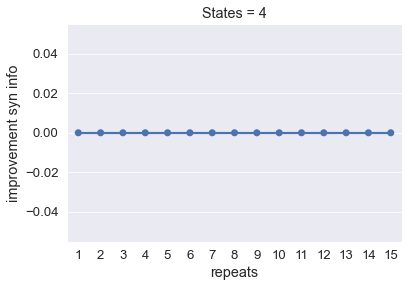

In [11]:
df = pd.read_pickle("../../results/test/convsyndisc"+str(states)+".pkl")
sns.set_context("paper", font_scale = 1.5)
pointplot=sns.pointplot(data=df,x='repeats',y='difference syn_info')
fig = pointplot.get_figure()

plt.ylabel("improvement syn info")
plt.xlabel("repeats")
plt.title("States = "+str(states))
# fig.savefig("out.png") 